# Introducción

Esta es una implementación de un modelo de aprendizaje profundo para la clasificación de imágenes de radiografías de tórax en dos categorías: Neumonía y Normal. El conjunto de datos utilizado se origina en el Centro Médico de Mujeres y Niños de Guangzhou, y comprende 5,863 imágenes de rayos X de pacientes pediátricos, organizadas en conjuntos de entrenamiento, prueba y validación.

La neumonía, especialmente en niños menores de 5 años, es una enfermedad común y potencialmente mortal, por lo que la detección temprana es crucial. Un modelo de aprendizaje profundo puede mejorar la velocidad y precisión del diagnóstico, siendo una herramienta valiosa para los profesionales médicos.

## Preparación

Esta sección configurará nuestro entorno, montará Google Drive y se conectará a Kaggle.

In [1]:
# Se importan las librerias principales para un modelo de deep learning.
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from tensorflow import keras
from sklearn.datasets import load_sample_image
from keras.preprocessing.image import ImageDataGenerator

# Se hace una configuración específica que permite mostrar gráficos en línea.
%matplotlib inline

In [2]:
# Importa lo necesario para montar Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Se elige el directorio donde se va a guardar el dataset.
%cd /content/drive/MyDrive/semestre_7/blumenkron/RetroDL

/content/drive/MyDrive/semestre_7/blumenkron/RetroDL


In [4]:
# Se obtiene el API de kaggle y se sube.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle (5).json': b'{"username":"nadiaferro","key":"c25dfdb8db1d847564fe15e8110a2c4d"}'}

In [5]:
# Se le otorgan los permisos necesarios.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Se comprueba que todo esta funcionando de forma correcta.
!kaggle datasets list

ref                                                            title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                DAIGT V2 Train Dataset                           29MB  2023-11-16 01:38:36           1027        113  1.0              
muhammadbinimran/housing-price-prediction-data                 Housing Price Prediction Data                   763KB  2023-11-21 17:56:32           3756         77  1.0              
carlmcbrideellis/llm-7-prompt-training-dataset                 LLM: 7 prompt training dataset                   41MB  2023-11-15 07:32:56           1381        107  1.0              
maso0dahmed/video-games-data                                   Video Games Data      

In [7]:
# Se descarga el dataset Chest X-Ray Images (Pneumonia).
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
# Se descomprime el archivo 'chest-xray-pneumonia.zip'.
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Despues de que descargar y descomprimir los datos que venian en el dataset, nos encontramos con esta estructura en la carpeta:

```
chest_xray/
...test/
...train/         
...val/         
```

Una de las cosas de las que nos podemos dar cuenta es que la informacion ya esta dividida en entrenamiento, validacion y prueba, por lo que ya no sera necesario que lo hagamos nosotros.

# Datos.
Ya que los datos ya estan separados en conjuntos de entrenamiento, validacion y prueba, vamos a revisar el contenido de uno de los conjuntos para ver con el tipo de datos con los que vamos a trabajar.

In [3]:
# Se definen las rutas que se van a estar utilizando.
test_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/test'
train_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/train'
val_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray/val'

In [4]:
# Se definen las rutas de las carpetas 'Normal' y 'Neumonia' para test.
test_nor = test_folder + '/NORMAL/'
test_neu = test_folder + '/PNEUMONIA/'

# Se definen las rutas de las carpetas 'Normal' y 'Neumonia' para train.
train_nor = train_folder + '/NORMAL/'
train_neu = train_folder + '/PNEUMONIA/'

# Se definen las rutas de las carpetas 'Normal' y 'Neumonia' para val.
val_nor = val_folder + '/NORMAL/'
val_neu = val_folder + '/PNEUMONIA/'

In [5]:
# Se selecciona una imagen 'Normal' aleatoria del conjunto train.
nor_rand = np.random.randint(0, len(os.listdir(train_nor)))
nor_num_foto = os.listdir(train_nor)[nor_rand]
nor_foto = train_nor + nor_num_foto

In [6]:
# Se selecciona una imagen 'Neumonia' aleatoria del conjunto train.
neu_rand = np.random.randint(0, len(os.listdir(train_neu)))
neu_num_foto = os.listdir(train_neu)[neu_rand]
neu_foto = train_neu + neu_num_foto

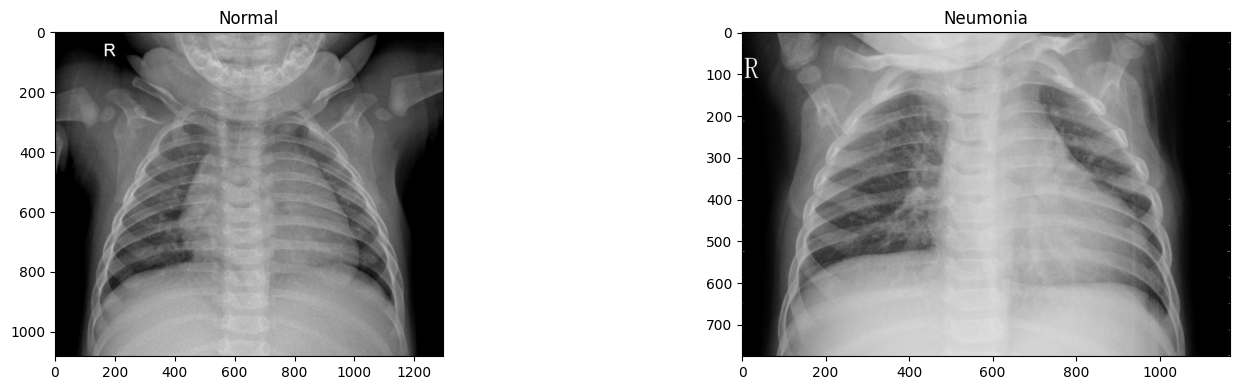

Foto Normal : IM-0554-0001.jpeg
Foto Neumonia: person911_virus_1567.jpeg


In [7]:
# Se cargan las dos imagenes.
nor_img = plt.imread(nor_foto)
neu_img = plt.imread(neu_foto)

# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la imagen 'Normal'.
plt.subplot(1, 2, 1)
plt.imshow(nor_img, cmap='gray')
plt.title('Normal')

# Se genera el subgrafico para la imagen 'Neumonia'.
plt.subplot(1, 2, 2)
plt.imshow(neu_img, cmap='gray')
plt.title('Neumonia')

# Se ajusta el diseño para evitar solapamientos.
plt.tight_layout()

# Se muestra la figura.
plt.show()

# Se imprime la información sobre las rutas de las imágenes.
print(f"Foto Normal : {nor_foto[88:]}")
print(f"Foto Neumonia: {neu_foto[91:]}")

Las imágenes anteriores se generan aleatoriamente a partir del conjunto de datos ya mencionado. Podemos notar que hay pequeñas diferencias entre las imagenes Normales y de Neumonia. Las principales diferencias es que en las imagenes con Neumonia nos encontramos con un aumento en la radioopacidad.

# Desarrollo del modelo.

Para el desarrollo del modelo se implementará un CNN con dos capas de convolución. Después de cada operación de convolución, se incorporará una capa de pooling utilizando la técnica de max-pooling.

Como estamos trabajando con un problema de clasificacion binaria es importante destacar que la salida consistirá en una única capa densa con una unidad y una función de activación sigmoide, ya que su tarea específica es predecir la presencia de neumonía en la imagen.

Por ultimo, para la compilación de nuestro modelo, se empleará la función de optimización Adam.

In [8]:
# Se crea un modelo secuencial.
model = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(64, 64, 3)),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Se muestra un resumen del modelo.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [9]:
# Se compila el modelo.
model.compile(
    loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])

In [10]:
# Se crea un generador de datos.
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Se configura el generador de datos para el conjunto de prueba.
test_generador = datagen.flow_from_directory(
    test_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Se configura el generador de datos para el conjunto de entrenamiento.
train_generador = datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Se configura el generador de datos para el conjunto de validación.
val_generador = datagen.flow_from_directory(
    val_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [12]:
# Se configura un callback para guardar el mejor modelo durante el entrenamiento.
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch", save_best_only=True, monitor="val_loss")]

# Se entrena el modelo.
history = model.fit(train_generador, epochs=6,
                    validation_data=val_generador, callbacks=callbacks)

Epoch 1/6
163/163 [==============================] - 69s 376ms/step - loss: 0.2413 - accuracy: 0.8988 - val_loss: 0.2683 - val_accuracy: 0.8750
Epoch 2/6
163/163 [==============================] - 56s 344ms/step - loss: 0.1113 - accuracy: 0.9548 - val_loss: 0.4700 - val_accuracy: 0.7500
Epoch 3/6
163/163 [==============================] - 58s 357ms/step - loss: 0.0914 - accuracy: 0.9664 - val_loss: 0.4891 - val_accuracy: 0.7500
Epoch 4/6
163/163 [==============================] - 58s 355ms/step - loss: 0.0808 - accuracy: 0.9712 - val_loss: 0.1538 - val_accuracy: 0.9375
Epoch 5/6
163/163 [==============================] - 59s 360ms/step - loss: 0.0716 - accuracy: 0.9732 - val_loss: 0.4868 - val_accuracy: 0.8125
Epoch 6/6
163/163 [==============================] - 57s 351ms/step - loss: 0.0626 - accuracy: 0.9757 - val_loss: 0.1858 - val_accuracy: 0.9375


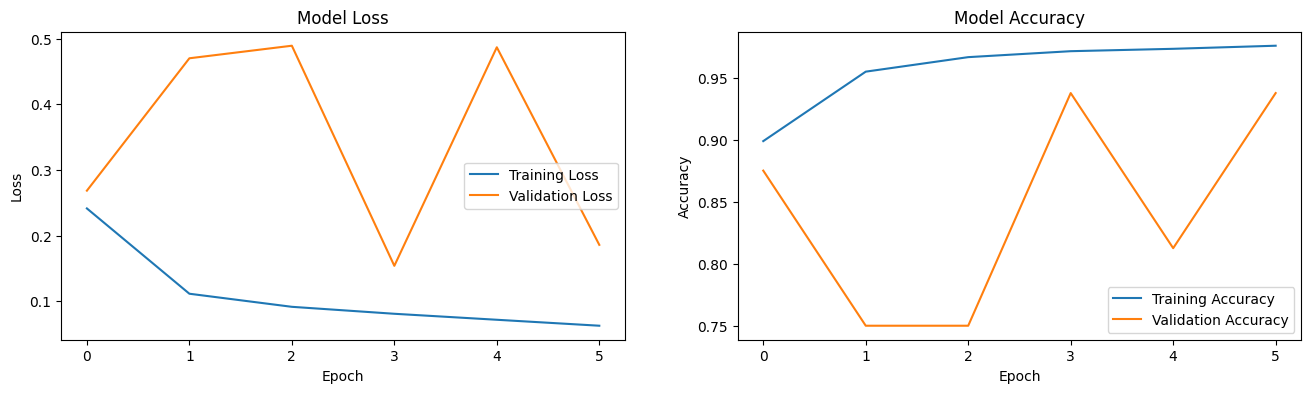

In [13]:
# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la grafica de perdida.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Se genera el subgrafico para la grafica de precisión.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Se muestran los graficos.
plt.show()

De acuerdo con los resultados se puede determinar que hay un problema de overfitting en el modelo.

Esto se puede observar en la precisión de el conjunto de entrenamiento el cual es considerablemente mayor que en el de validacion. Por otro lado, la perdida en el conjunto de entrenamiento es baja a diferencia de la del conjunto de validación la cual se encuentra considerablemente mas alta en algunas epocas.

In [14]:
# Se evalua el modelo en el conjunto de prueba.
test_loss, test_acc = model.evaluate(test_generador)

# Se muestran la perdida y la precisión en el conjunto de prueba.
print(f"Perdida en el test set: {test_loss}")
print(f"Precisión en el test set: {test_acc}")

20/20 [==============================] - 233s 12s/step - loss: 0.8017 - accuracy: 0.8013
Perdida en el test set: 0.801654577255249
Precisión en el test set: 0.8012820482254028


En la evaluacion se puede observar que la pérdida y la precisión en el conjunto de prueba son moderadas, pero que no son tan buenas como las métricas en el conjunto de entrenamiento.

## Ajuste del modelo.

Como vimos en las graficas anteriores el modelo cuenta con un problema de overfitting. El overfitting puede deberse a una cantidad insuficiente de datos de entrenamiento, por lo que hay que usar tecnicas para poder combatir este problema.

Para este problema vamos a utilizar la incorporación de técnicas de data augmentation, como cortes, cambio de zoom, etc. las cuales generan variabilidad en nuestros datos de entrenamiento, ayudando al modelo a generalizar mejor a datos no vistos.

In [15]:
# Se configuran los datos del Data Augmentation.
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Se configurar el generador de datos de entrenamiento con Data Augmentation.
train_generador_augmented = train_datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [16]:
# Se compila el modelo nuevamente después de aplicar el Data Augmentation.
model.compile(
    loss = 'binary_crossentropy', optimizer = 'adam',  metrics = ['accuracy'])

# Se entrena el modelo con el generador de datos de entrenamiento aumentado.
history_augmented = model.fit(
    train_generador_augmented,
    epochs=11,
    validation_data=val_generador,
)

Epoch 1/11
163/163 [==============================] - 68s 380ms/step - loss: 8.9624 - accuracy: 0.8635 - val_loss: 0.6230 - val_accuracy: 0.5625
Epoch 2/11
163/163 [==============================] - 62s 381ms/step - loss: 0.7967 - accuracy: 0.8819 - val_loss: 0.6681 - val_accuracy: 0.5000
Epoch 3/11
163/163 [==============================] - 66s 404ms/step - loss: 0.3627 - accuracy: 0.9011 - val_loss: 0.6769 - val_accuracy: 0.5000
Epoch 4/11
163/163 [==============================] - 66s 404ms/step - loss: 0.2855 - accuracy: 0.9068 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 5/11
163/163 [==============================] - 66s 403ms/step - loss: 0.2396 - accuracy: 0.9135 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 6/11
163/163 [==============================] - 64s 396ms/step - loss: 0.2117 - accuracy: 0.9237 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 7/11
163/163 [==============================] - 64s 396ms/step - loss: 0.2025 - accuracy: 0.9222 - val_loss: 0.6901 - val_ac

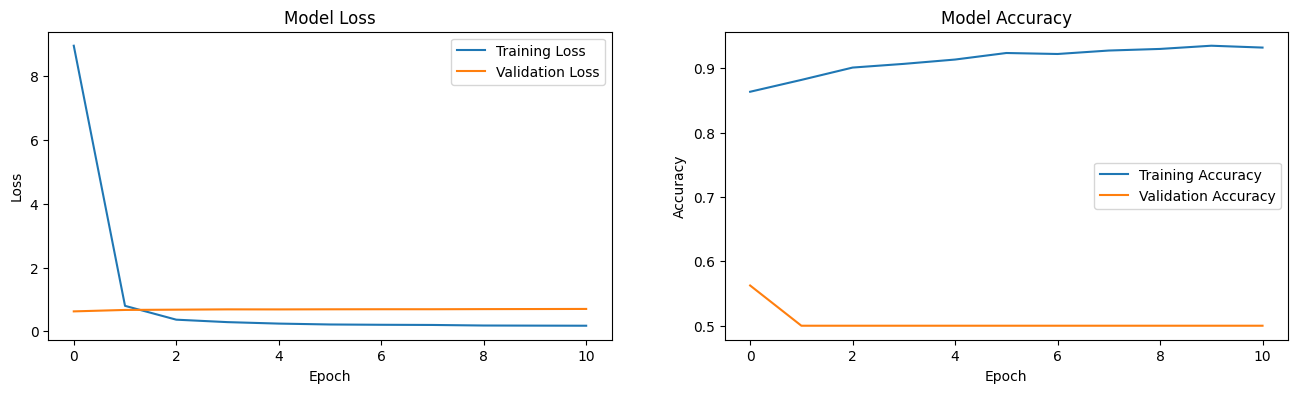

In [17]:
# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la grafica de perdida.
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['loss'], label='Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Se genera el subgrafico para la grafica de precisión.
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Se muestran los graficos.
plt.show()

Aunque el modelo inicial mostró buenos resultados en el conjunto de entrenamiento, se observó un problema de overfitting al evaluarlo en el conjunto de validación. Para abordar este problema, se aplicaron técnicas de aumento de datos, como cortes, cambio de zoom y volteo horizontal.

A pesar de abordar este problema con data augmentation, no se lograron los resultados esperados, por lo que otras posible mejora puede ser la contruccion de una arquitectura de modelo más compleja, ajustes adicionales en los hiperparámetros del modelo, etc.

Además, la expansión del conjunto de datos o la búsqueda de conjuntos de datos adicionales podrían contribuir a una mejora significativa en la generalización del modelo.

## Ajuste del modelo version 2

Para abordar el problema que tuvimos en los ultimos dos modelos, vamos a dividir la cantidad de imagenes que hay en las carpetas del dataset. Despues vamos a cambiar la arquitectura del modelo.

In [18]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [19]:
# Cambiar al directorio principal
os.chdir('/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/')

In [20]:
# Definir las rutas de los directorios de entrada y salida
input_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray'
output_folder = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray_split'

In [21]:
# Listar todas las imágenes en los directorios 'NORMAL' y 'PNEUMONIA'
nor_img_test = [file for file in os.listdir(test_nor) if file.endswith('.jpeg')]
neu_img_test = [file for file in os.listdir(test_neu) if file.endswith('.jpeg')]

nor_img_train = [file for file in os.listdir(train_nor) if file.endswith('.jpeg')]
neu_img_train = [file for file in os.listdir(train_neu) if file.endswith('.jpeg')]

nor_img_val = [file for file in os.listdir(val_nor) if file.endswith('.jpeg')]
neu_img_val = [file for file in os.listdir(val_neu) if file.endswith('.jpeg')]

In [22]:
# Combinar las listas de imágenes de 'NORMAL' y 'PNEUMONIA'
all_images = nor_img_test + neu_img_test + nor_img_train + neu_img_train + nor_img_val + neu_img_val

# Dividir los datos en train, val y test
train_images, test_val_images = train_test_split(all_images, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(test_val_images, test_size=0.33, random_state=42)

In [ ]:
# Crear la estructura de carpetas
os.mkdir(output_folder)

for folder in ['train', 'val', 'test']:
    os.mkdir(os.path.join(output_folder, folder))
    os.mkdir(os.path.join(output_folder, folder, 'NORMAL'))
    os.mkdir(os.path.join(output_folder, folder, 'PNEUMONIA'))

In [24]:
def copy_images(source_folder, destination_folder, image_list):
    for img in image_list:
        subfolder = 'NORMAL' if 'NORMAL' in img else 'PNEUMONIA'
        origin = os.path.join(input_folder, source_folder, subfolder, img)
        destination = os.path.join(output_folder, destination_folder, subfolder, img)

        # Verificar si el archivo existe antes de intentar copiarlo
        if os.path.exists(origin):
            shutil.copyfile(origin, destination)
        else:
            print(f"El archivo {img} no existe en la carpeta {source_folder}")

# Copiar imágenes a las carpetas correspondientes
copy_images('train', 'train', train_images)
copy_images('train', 'val', val_images)
copy_images('train', 'test', test_images)


El archivo person64_virus_122.jpeg no existe en la carpeta train
El archivo IM-0391-0001.jpeg no existe en la carpeta train
El archivo NORMAL2-IM-0304-0001.jpeg no existe en la carpeta train
El archivo person134_bacteria_644.jpeg no existe en la carpeta train
El archivo person96_bacteria_466.jpeg no existe en la carpeta train
El archivo person150_bacteria_716.jpeg no existe en la carpeta train
El archivo person158_bacteria_742.jpeg no existe en la carpeta train
El archivo IM-0421-0001.jpeg no existe en la carpeta train
El archivo IM-0496-0001.jpeg no existe en la carpeta train
El archivo person154_bacteria_728.jpeg no existe en la carpeta train
El archivo NORMAL2-IM-0360-0001.jpeg no existe en la carpeta train
El archivo person1_virus_11.jpeg no existe en la carpeta train
El archivo NORMAL2-IM-0323-0001.jpeg no existe en la carpeta train
El archivo IM-0105-0001.jpeg no existe en la carpeta train
El archivo NORMAL2-IM-0285-0001.jpeg no existe en la carpeta train
El archivo IM-0519-0001-

In [25]:
# Obtener la cantidad de imágenes en cada conjunto
num_train = len(os.listdir(os.path.join(output_folder, 'train', 'NORMAL'))) + len(os.listdir(os.path.join(output_folder, 'train', 'PNEUMONIA')))
num_val = len(os.listdir(os.path.join(output_folder, 'val', 'NORMAL'))) + len(os.listdir(os.path.join(output_folder, 'val', 'PNEUMONIA')))
num_test = len(os.listdir(os.path.join(output_folder, 'test', 'NORMAL'))) + len(os.listdir(os.path.join(output_folder, 'test', 'PNEUMONIA')))

# Imprimir la información
print('Número de imágenes en el conjunto de entrenamiento:', num_train)
print('Número de imágenes en el conjunto de validación:', num_val)
print('Número de imágenes en el conjunto de prueba:', num_test)


Número de imágenes en el conjunto de entrenamiento: 3264
Número de imágenes en el conjunto de validación: 899
Número de imágenes en el conjunto de prueba: 456


In [26]:
# Se definen las rutas que se van a estar utilizando.
test_folder_split = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray_split/test'
train_folder_split = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray_split/train'
val_folder_split = '/content/drive/MyDrive/semestre_7/blumenkron/RetroDL/chest_xray/chest_xray_split/val'

In [27]:
# Se crea un nuevo modelo secuencial.
new_model = keras.Sequential([
    layers.InputLayer(input_shape=(64, 64, 1)),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Se configuran los datos del Data Augmentation.
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [29]:
# Se configura el generador de datos de entrenamiento con Data Augmentation.
test_generador_augmented = test_datagen.flow_from_directory(
    test_folder_split,
    target_size=(64, 64),
    batch_size=128,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False,
    seed=42
)

train_generador_augmented = train_datagen.flow_from_directory(
    train_folder_split,
    target_size=(64, 64),
    batch_size=128,
    color_mode = 'grayscale',
    class_mode='binary',
    shuffle = True,
    seed=42
)

val_generador_augmented = val_datagen.flow_from_directory(
    val_folder_split,
    target_size=(64, 64),
    batch_size=128,
    color_mode = 'grayscale',
    class_mode='binary',
    shuffle = False,
    seed=42
)

Found 456 images belonging to 2 classes.
Found 3264 images belonging to 2 classes.
Found 899 images belonging to 2 classes.


In [30]:
# Se entrena el modelo con el generador de datos de entrenamiento aumentado.
history_augmented = new_model.fit(
    train_generador_augmented,
    epochs=20,
    steps_per_epoch = len(train_generador_augmented),
    validation_data=val_generador_augmented,
    validation_steps = len(val_generador_augmented),
)

Epoch 1/20
26/26 [==============================] - 35s 1s/step - loss: 0.5054 - accuracy: 0.8140 - val_loss: 0.4656 - val_accuracy: 0.8309
Epoch 2/20
26/26 [==============================] - 31s 1s/step - loss: 0.4464 - accuracy: 0.8404 - val_loss: 0.4422 - val_accuracy: 0.8309
Epoch 3/20
26/26 [==============================] - 30s 1s/step - loss: 0.4130 - accuracy: 0.8404 - val_loss: 0.3676 - val_accuracy: 0.8309
Epoch 4/20
26/26 [==============================] - 31s 1s/step - loss: 0.3180 - accuracy: 0.8483 - val_loss: 0.3256 - val_accuracy: 0.9166
Epoch 5/20
26/26 [==============================] - 31s 1s/step - loss: 0.2430 - accuracy: 0.9013 - val_loss: 0.2826 - val_accuracy: 0.8676
Epoch 6/20
26/26 [==============================] - 31s 1s/step - loss: 0.2275 - accuracy: 0.9023 - val_loss: 0.1959 - val_accuracy: 0.9244
Epoch 7/20
26/26 [==============================] - 34s 1s/step - loss: 0.2054 - accuracy: 0.9167 - val_loss: 0.3660 - val_accuracy: 0.8109
Epoch 8/20
26/26 [==

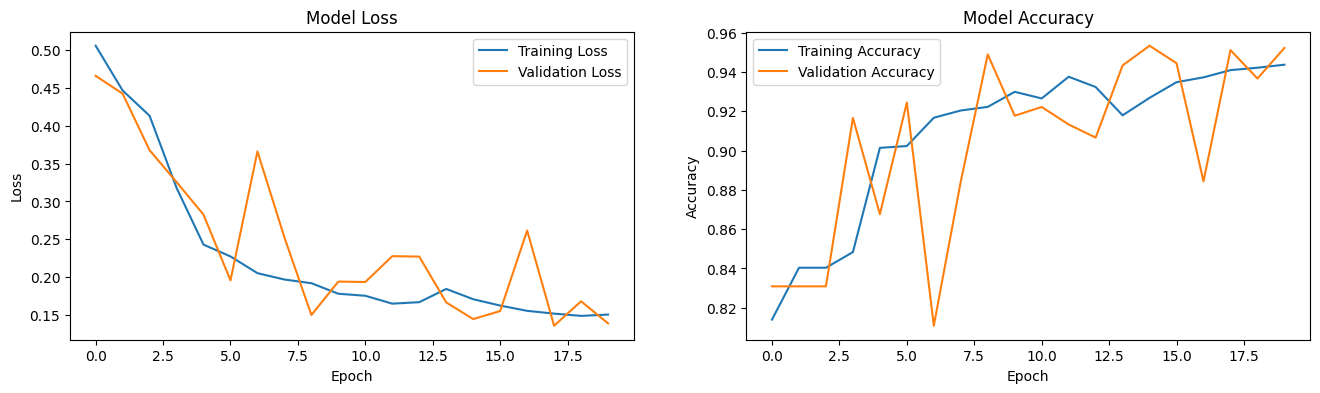

In [31]:
# Se configura el tamaño de la figura.
plt.figure(figsize=(16, 4))

# Se genera el subgrafico para la grafica de perdida.
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['loss'], label='Training Loss')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Se genera el subgrafico para la grafica de precisión.
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['accuracy'], label='Training Accuracy')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Se muestran los graficos.
plt.show()

# Resultados.

 A continuacion vamos a realizar algunas predicciones utilizando el modelo entrenado.

8/8 [==============================] - 7s 652ms/step


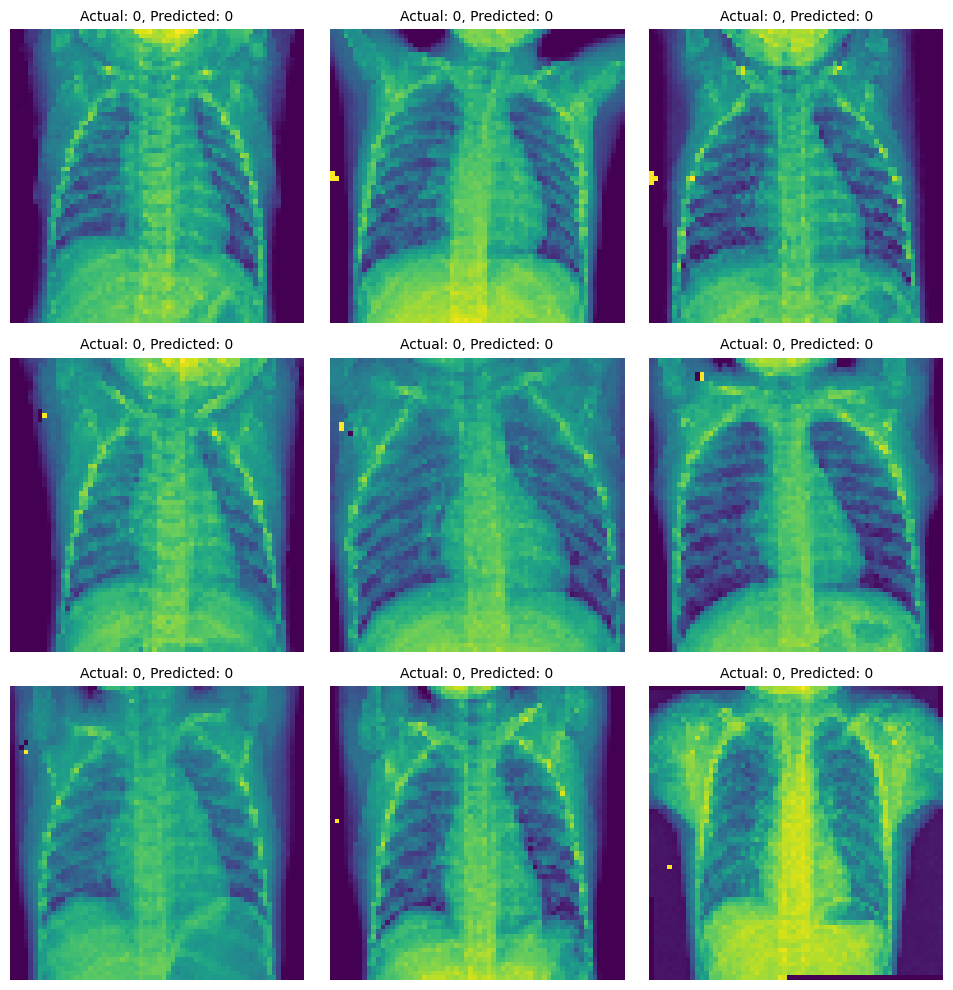

In [32]:

prediction = new_model.predict(val_generador_augmented)

prediction_labels = []
for i in prediction:
    if i > 0.5:
        prediction_labels.append(1)
    else:
        prediction_labels.append(0)

images, labels = val_generador_augmented.next()

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(f"Actual: {val_generador_augmented.class_indices['PNEUMONIA' if labels[i] == 1 else 'NORMAL']}, Predicted: {prediction_labels[i]}", fontsize=10)
    plt.axis(False)
    plt.tight_layout()

plt.show()

In [33]:
from IPython.display import display, HTML
from ipywidgets import FileUpload, Output
import numpy as np
from PIL import Image

# Crear un cuadro de carga de archivos
upload = FileUpload()

# Crear un contenedor de salida
output = Output()

# Función para manejar la carga de archivos y realizar predicciones
def on_upload(change):
    with output:
        output.clear_output()
        for filename, content in upload.value.items():
            # Guardar la imagen cargada
            with open(filename, 'wb') as f:
                f.write(content['content'])

            # Cargar la imagen y preprocesarla según las necesidades del modelo
            img = Image.open(filename).convert("L")  # Convertir a escala de grises
            img = img.resize((64, 64))  # Ajustar al tamaño de entrada del modelo
            img_array = np.expand_dims(np.array(img) / 255.0, axis=0)  # Normalizar y agregar dimensión de lote

            # Realizar la predicción
            prediction = new_model.predict(img_array)

            # Mostrar la imagen y la predicción
            display(img)
            if prediction[0][0] > 0.5:
                print("Predicción: NEUMONIA")
            else:
                print("Predicción: NORMAL")

# Asociar la función de manejo a la carga de archivos
upload.observe(on_upload, names='_counter')

# Mostrar los widgets
display(upload)
display(output)

FileUpload(value={}, description='Upload')

Output()

# Conclusiones.

Aunque el modelo inicial mostró buenos resultados en el conjunto de entrenamiento, se observó un problema de overfitting al evaluarlo en el conjunto de validación. Para abordar este problema, se aplicaron técnicas de aumento de datos, como cortes, cambio de zoom y volteo horizontal.

A pesar de abordar este problema con data augmentation, no se lograron los resultados esperados.

Por lo que despues se abordo el problema con la contruccion de una arquitectura de modelo más compleja, ajustes diferentes en los hiperparámetros del modelo y cambiando la distribucion de las imagenes.

Despues de esas modificacion conseguimos cambios significativos.